In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%pylab inline

tweets = pd.read_csv('train.csv', encoding='latin-1')
tweets['longitud'] = tweets['text'].str.len()
tweets.head()

Populating the interactive namespace from numpy and matplotlib


,id,keyword,location,text,target,texto_longitud
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [9]:
tweets_description = tweets['longitud'].describe()

tweets_description = tweets_description.to_frame()
tweets_description.rename(index={'mean':'promedio', 'min':'mínimo', 'max':'máximo'}, inplace=True)
tweets_description.drop(['count', 'std', '25%', '50%', '75%'], inplace=True)
tweets_description['longitud'] = tweets_description['longitud'].astype(int)
tweets_description

,texto_longitud
promedio,101
mínimo,7
máximo,163


In [10]:
bins = pd.cut(tweets['texto_longitud'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180])
tweets['bin'] = bins
tweets

,id,keyword,location,text,target,texto_longitud,bin
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"(60, 80]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"(20, 40]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"(120, 140]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"(60, 80]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"(80, 100]"
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,"(80, 100]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,"(120, 140]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,"(60, 80]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,"(120, 140]"


In [11]:
tweets_percentage = tweets.groupby('bin').agg({'target':'mean'})
tweets_percentage['target'] = round(tweets_percentage['target'] * 100, 2);
tweets_percentage.rename(columns={'target':'porcentaje'}, inplace=True)
tweets_percentage

,porcentaje
bin,
"(0, 20]",8.97
"(20, 40]",18.48
"(40, 60]",26.36
"(60, 80]",36.59
"(80, 100]",48.32
"(100, 120]",45.40
"(120, 140]",50.10
"(140, 160]",46.05
"(160, 180]",50.00


KeyError: 'longitud'

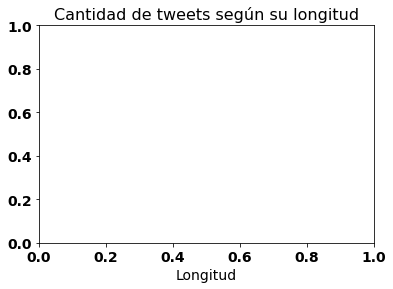

In [12]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.weight'] = 'bold'

fig = plt.figure()
ax = fig.add_subplot(111)

plt.title('Cantidad de tweets según su longitud', fontsize=16)
ax.set_xlabel('Longitud')
tweets['longitud'].plot.kde(color='darksalmon', figsize=(16, 8))

plt.show()